# Deep Learning - First mini-project - Solange Pruilh

In [1]:
import keras as K
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib.patches as patches
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D
from keras.optimizers import RMSprop,Adam, SGD
from keras.callbacks import EarlyStopping

# Functions

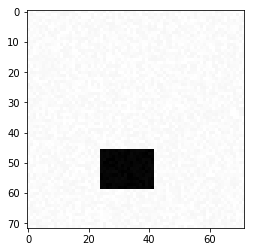

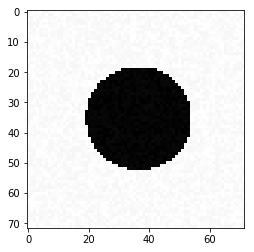

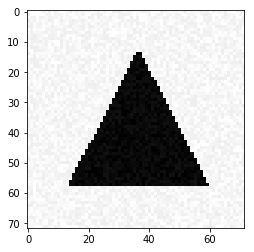

In [3]:
# %load mp1.py

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

plt.figure()
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.figure()
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.figure()
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [4]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, free_location)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]



def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray') #
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3 - Simple classification

## Perceptron with fixed shapes train dataset, and changing shapes test dataset

In [574]:
[X_train,Y_train] =  generate_dataset_classification(300,20,False)
Y_train_keras = np_utils.to_categorical(Y_train)

X_test,Y_test = generate_test_set_classification(free_location=True)

Creating data:
0
100
200
Creating data:
0
100
200


In [575]:
model = Sequential()
model.add(Dense(3,input_shape = (X_train.shape[1],),activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
num_epochs = 10
model.fit(X_train, Y_train_keras, batch_size=batch_size, epochs=num_epochs,verbose=1, validation_data=(X_test, Y_test))
print('Evaluate')
model.evaluate(X_test, Y_test, verbose=1)

Train on 300 samples, validate on 300 samples
Epoch 1/10
300/300 [==============================] - 2s 6ms/step - loss: 2.4704 - acc: 0.3167 - val_loss: 2.5845 - val_acc: 0.3333
Epoch 2/10
300/300 [==============================] - 0s 249us/step - loss: 1.1890 - acc: 0.4633 - val_loss: 1.6384 - val_acc: 0.3300
Epoch 3/10
300/300 [==============================] - 0s 249us/step - loss: 0.7095 - acc: 0.6933 - val_loss: 2.0845 - val_acc: 0.3133
Epoch 4/10
300/300 [==============================] - 0s 249us/step - loss: 0.6390 - acc: 0.6700 - val_loss: 3.0615 - val_acc: 0.3667
Epoch 5/10
300/300 [==============================] - 0s 243us/step - loss: 0.3940 - acc: 0.8600 - val_loss: 1.7797 - val_acc: 0.2700
Epoch 6/10
300/300 [==============================] - 0s 259us/step - loss: 0.3445 - acc: 0.8200 - val_loss: 2.6348 - val_acc: 0.3867
Epoch 7/10
300/300 [==============================] - 0s 236us/step - loss: 0.3972 - acc: 0.7633 - val_loss: 2.2089 - val_acc: 0.3533
Epoch 8/10
300/300

[2.3429005336761475, 0.33666666666666667]

## Perceptron with fixed shapes train dataset, and fixed shapes test dataset

In [565]:
[X_train,Y_train] =  generate_dataset_classification(300,20)
Y_train_keras = np_utils.to_categorical(Y_train)

X_test,Y_test = generate_test_set_classification(free_location=False)

Creating data:
0
100
200
Creating data:
0
100
200


In [566]:
model = Sequential()
model.add(Dense(3,input_shape = (X_train.shape[1],),activation='softmax'))

In [567]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [568]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [569]:
batch_size = 32
num_epochs = 10
model.fit(X_train, Y_train_keras, batch_size=batch_size, epochs=num_epochs,verbose=1, validation_data=(X_test, Y_test))


Train on 300 samples, validate on 300 samples
Epoch 1/10
300/300 [==============================] - 2s 6ms/step - loss: 2.0941 - acc: 0.3967 - val_loss: 1.0061 - val_acc: 0.4133
Epoch 2/10
300/300 [==============================] - 0s 266us/step - loss: 0.9485 - acc: 0.5533 - val_loss: 0.5861 - val_acc: 0.7600
Epoch 3/10
300/300 [==============================] - 0s 276us/step - loss: 0.5527 - acc: 0.7533 - val_loss: 0.5401 - val_acc: 0.7067
Epoch 4/10
300/300 [==============================] - 0s 249us/step - loss: 0.4469 - acc: 0.8233 - val_loss: 0.5740 - val_acc: 0.6567
Epoch 5/10
300/300 [==============================] - 0s 289us/step - loss: 0.3682 - acc: 0.8667 - val_loss: 0.3412 - val_acc: 0.8467
Epoch 6/10
300/300 [==============================] - 0s 263us/step - loss: 0.3601 - acc: 0.8133 - val_loss: 0.3116 - val_acc: 0.8233
Epoch 7/10
300/300 [==============================] - 0s 289us/step - loss: 0.2647 - acc: 0.9133 - val_loss: 0.3091 - val_acc: 0.8467
Epoch 8/10
300/300

In [570]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Score evaluation',score)

300/300 [==============================] - 0s 106us/step
Score evaluation [0.23535522878170012, 0.93666666746139526]


In [571]:
X_test_1 = generate_a_disk()
X_test_1 = X_test_1.reshape(1, X_test_1.shape[0])
model.predict(X_test_1)

array([[ 0.,  1.,  0.]], dtype=float32)

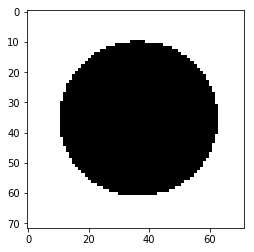

In [572]:
plt.imshow(X_test_1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

**Observation** 

In order to be able to predict shape with a  simple perceptron, I consider dataset without free location for training and testing. If we consider free location for test dataset, like for the very first perceptron, we won't well predict this set, because during learning, the network only saw "formatted" shapes. 

By testing sgd and adam optimizers, adam optimizer seems to be the best choice for following problems, combining advantages of extensions of stochastic gradient descent.

# 4 - Check weights

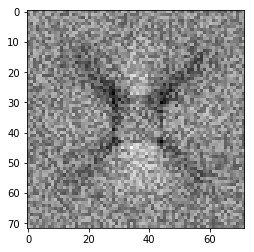

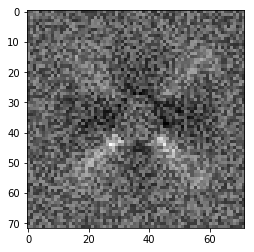

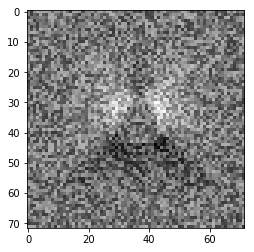

In [332]:
for i in range(3):
    plt.figure()
    plt.imshow(model.get_weights()[0][:,i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


** Observation ** 
Here, we visualize weights of the matrix, as 3 matrices, one for each predicted class, and we can guess the shape in each of the images.

# 5 - A more difficult classification problem

In [600]:
[X_train, Y_train] = generate_dataset_classification(2500, 20, True)
Y_train_keras =  np_utils.to_categorical(Y_train, 3) 
[X_test, Y_test] = generate_test_set_classification(True)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
Creating data:
0
100
200


### Re-train the same model

In [601]:
model = Sequential()
model.add(Dense(3,input_shape = (X_train.shape[1],),activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
num_epochs = 50
batch_size = 128
model.fit(X_train, Y_train_keras, batch_size=batch_size, epochs=num_epochs,verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

Train on 2500 samples, validate on 300 samples
Epoch 1/50
2500/2500 [==============================] - 2s 770us/step - loss: 1.2340 - acc: 0.3856 - val_loss: 1.0205 - val_acc: 0.4733
Epoch 2/50
2500/2500 [==============================] - 0s 95us/step - loss: 1.0339 - acc: 0.4836 - val_loss: 0.9685 - val_acc: 0.5033
Epoch 3/50
2500/2500 [==============================] - 0s 105us/step - loss: 0.9259 - acc: 0.5248 - val_loss: 0.9019 - val_acc: 0.5600
Epoch 4/50
2500/2500 [==============================] - 0s 107us/step - loss: 0.8765 - acc: 0.5648 - val_loss: 0.9129 - val_acc: 0.5867
Epoch 5/50
2500/2500 [==============================] - 0s 113us/step - loss: 0.8589 - acc: 0.5588 - val_loss: 0.8581 - val_acc: 0.5667
Epoch 6/50
2500/2500 [==============================] - 0s 111us/step - loss: 0.8322 - acc: 0.5844 - val_loss: 0.8508 - val_acc: 0.5467
Epoch 7/50
2500/2500 [==============================] - 0s 109us/step - loss: 0.8247 - acc: 0.5876 - val_loss: 0.8485 - val_acc: 0.5767
Ep

In [602]:
print('Score [loss, accuracy]',score)

Score [loss, accuracy] [0.77179670254389443, 0.58666666587193805]


**Observation** 

The precedent model, with only a Dense layer is here not adapted to datasets with moving shapes.Even if we reach accuracy of around 58% for test data, we could consider a more complex model, and convolutional layers are known to perform on images challenges.


## A Convolutional Neural Network

In [603]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
X_train = X_train.astype('float32')

X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
X_test = X_test.astype('float32')

input_shape = (IMAGE_SIZE, IMAGE_SIZE,1)
print(input_shape)

(72, 72, 1)


In [604]:
nb_filters = 64 
nb_neurons = 64
filter_size = (5,5)
model = Sequential()
model.add(Conv2D(nb_filters,kernel_size=filter_size,input_shape = input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

In [605]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 68, 68, 64)        1664      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 34, 34, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 34, 34, 64)        0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 73984)             0         
_________________________________________________________________
dense_97 (Dense)             (None, 64)                4735040   
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 3)                 195       
Total para

In [606]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

num_epochs = 20
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.0, patience=3)
callbacks=[early_stopping]
model.fit(X_train, Y_train_keras, batch_size=batch_size, epochs=num_epochs,verbose=1, validation_data=(X_test, Y_test),callbacks=callbacks)
score = model.evaluate(X_test, Y_test, verbose=0)

Train on 2500 samples, validate on 300 samples
Epoch 1/20
2500/2500 [==============================] - 33s 13ms/step - loss: 1.0794 - acc: 0.5920 - val_loss: 0.7138 - val_acc: 0.6667
Epoch 2/20
2500/2500 [==============================] - 32s 13ms/step - loss: 0.6658 - acc: 0.7156 - val_loss: 0.6328 - val_acc: 0.6833
Epoch 3/20
2500/2500 [==============================] - 32s 13ms/step - loss: 0.5480 - acc: 0.7912 - val_loss: 1.0290 - val_acc: 0.6267
Epoch 4/20
2500/2500 [==============================] - 35s 14ms/step - loss: 0.4583 - acc: 0.8344 - val_loss: 0.4195 - val_acc: 0.8500
Epoch 5/20
2500/2500 [==============================] - 30s 12ms/step - loss: 0.3726 - acc: 0.8804 - val_loss: 0.3392 - val_acc: 0.8933
Epoch 6/20
2500/2500 [==============================] - 31s 13ms/step - loss: 0.2584 - acc: 0.9208 - val_loss: 0.2765 - val_acc: 0.9233
Epoch 7/20
2500/2500 [==============================] - 36s 14ms/step - loss: 0.2142 - acc: 0.9368 - val_loss: 0.2790 - val_acc: 0.8933
E

In [607]:
print('Score [loss function, accuracy]',score)

Score [loss function, accuracy] [0.21868940154711405, 0.93666666746139526]


**Observation**

Givent this structure of CNN, add more neurons into the network only increases time cost, without increasing efficiency. The current network is already correct for this problem, even if it can be improved by testing more complex architectures.

The accuracy could be improved by increasing the size of training set.

# 6 -  A regression problem : find vertices of a triangle

In [5]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Creating data:
0
100
200


## Normalisation

In [6]:
##############
# Sort Y_train 
##############
for i in range(Y_train.shape[0]):
    sorted_y = Y_train[i].reshape(3,2)
    if np.unique(sorted_y[:,0]).shape[0]==3 :
        sorted_y = sorted_y[sorted_y[:,0].argsort()]
        Y_train[i] = sorted_y.flatten()
    else : 
        sorted_y = sorted_y[sorted_y[:,0].argsort()]
        for i in range(2):
            if (sorted_y[i,0] == sorted_y[i+1,0] & sorted_y[i,1] > sorted_y[i+1,1]) :
                copie = sorted_y[i]
                sorted_y[i] = sorted_y[i+1]
                sorted_y[i+1] =  copie
        Y_train[i] = sorted_y.flatten()
        
###########
# Sort Y_test
##########

for i in range(Y_test.shape[0]):
    sorted_y = Y_test[i].reshape(3,2)
    if np.unique(sorted_y[:,0]).shape[0]==3 :
        sorted_y = sorted_y[sorted_y[:,0].argsort()]
        Y_test[i] = sorted_y.flatten()
    else : 
        sorted_y = sorted_y[sorted_y[:,0].argsort()]
        for i in range(2):
            if (sorted_y[i,0] == sorted_y[i+1,0] & sorted_y[i,1] > sorted_y[i+1,1]) :
                copie = sorted_y[i]
                sorted_y[i] = sorted_y[i+1]
                sorted_y[i+1] =  copie
        Y_test[i] = sorted_y.flatten()

In [7]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
X_train = X_train.astype('float32')

X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
X_test = X_test.astype('float32')

input_shape = (IMAGE_SIZE, IMAGE_SIZE,1)
print(input_shape)

(72, 72, 1)


In [8]:
kernel_size = (5,5)

model=Sequential()

model.add(Conv2D(64, kernel_size, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, kernel_size, activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size, activation='relu')) 
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(6))


adam =Adam(lr=0.0001) # par défaut 0.001
model.compile(loss='mean_squared_error',
optimizer=adam)


batch_size = 64
num_epochs = 150
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.0, patience=4)
callbacks=[early_stopping]
model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,verbose=1, validation_data=(X_test, Y_test))



Train on 3000 samples, validate on 300 samples
Epoch 1/150
3000/3000 [==============================] - 92s 31ms/step - loss: 0.1014 - val_loss: 0.1033
Epoch 2/150
3000/3000 [==============================] - 96s 32ms/step - loss: 0.0599 - val_loss: 0.0802
Epoch 3/150
3000/3000 [==============================] - 98s 33ms/step - loss: 0.0474 - val_loss: 0.0733
Epoch 4/150
3000/3000 [==============================] - 103s 34ms/step - loss: 0.0407 - val_loss: 0.0675
Epoch 5/150
3000/3000 [==============================] - 131s 44ms/step - loss: 0.0371 - val_loss: 0.0717
Epoch 6/150
3000/3000 [==============================] - 114s 38ms/step - loss: 0.0338 - val_loss: 0.0618
Epoch 7/150
3000/3000 [==============================] - 99s 33ms/step - loss: 0.0311 - val_loss: 0.0622
Epoch 8/150
3000/3000 [==============================] - 101s 34ms/step - loss: 0.0288 - val_loss: 0.0601
Epoch 9/150
3000/3000 [==============================] - 100s 33ms/step - loss: 0.0274 - val_loss: 0.0548
Epo

Epoch 78/150
3000/3000 [==============================] - 97s 32ms/step - loss: 0.0061 - val_loss: 0.0153
Epoch 79/150
3000/3000 [==============================] - 95s 32ms/step - loss: 0.0060 - val_loss: 0.0150
Epoch 80/150
3000/3000 [==============================] - 95s 32ms/step - loss: 0.0058 - val_loss: 0.0153
Epoch 81/150
3000/3000 [==============================] - 95s 32ms/step - loss: 0.0058 - val_loss: 0.0165
Epoch 82/150
3000/3000 [==============================] - 95s 32ms/step - loss: 0.0058 - val_loss: 0.0153
Epoch 83/150
3000/3000 [==============================] - 95s 32ms/step - loss: 0.0057 - val_loss: 0.0150
Epoch 84/150
3000/3000 [==============================] - 96s 32ms/step - loss: 0.0058 - val_loss: 0.0149
Epoch 85/150
3000/3000 [==============================] - 95s 32ms/step - loss: 0.0056 - val_loss: 0.0145
Epoch 86/150
3000/3000 [==============================] - 95s 32ms/step - loss: 0.0056 - val_loss: 0.0135
Epoch 87/150
3000/3000 [======================

In [618]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)
Y_pred = model.predict(X_test)

0.00810484817872


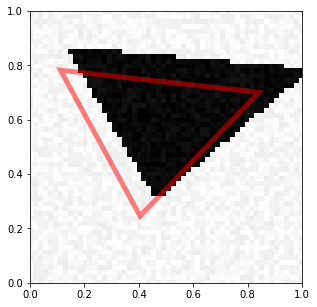

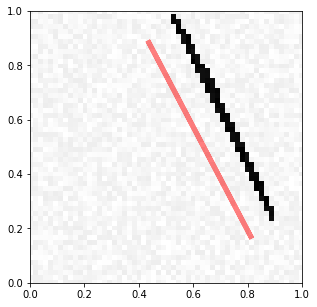

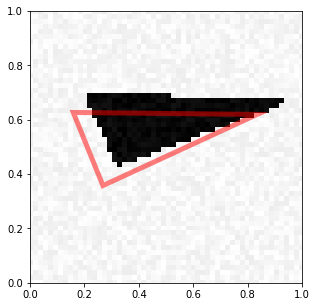

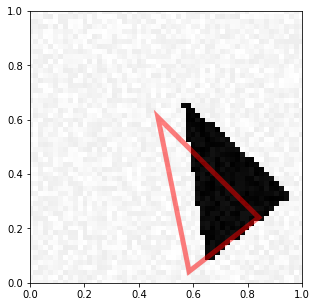

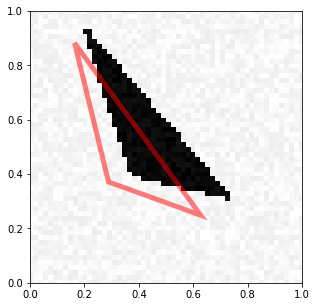

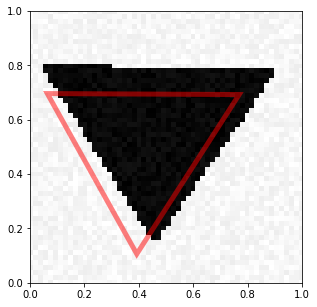

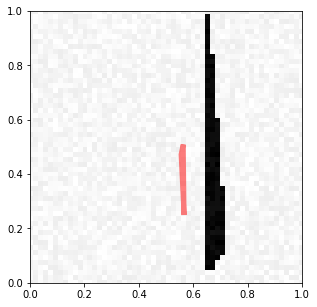

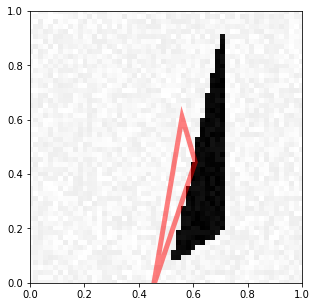

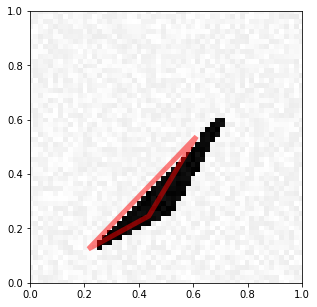

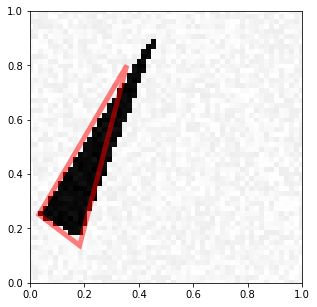

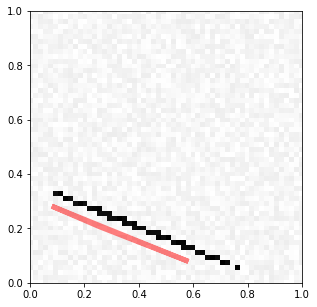

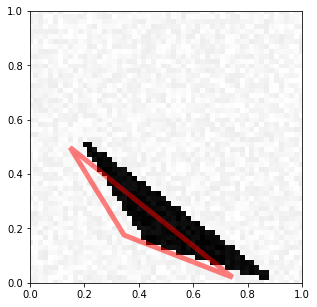

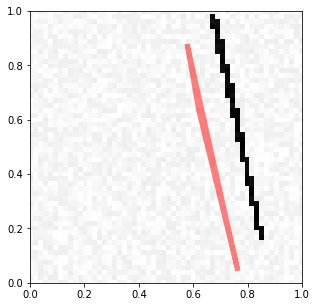

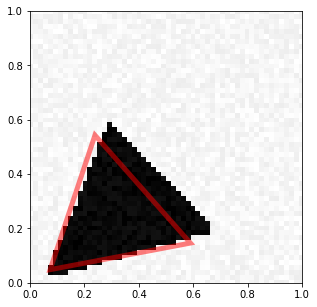

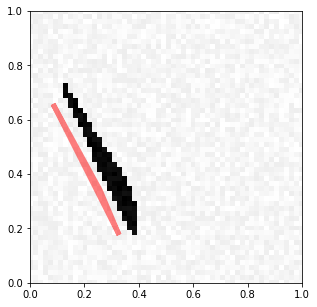

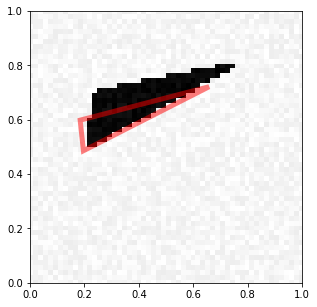

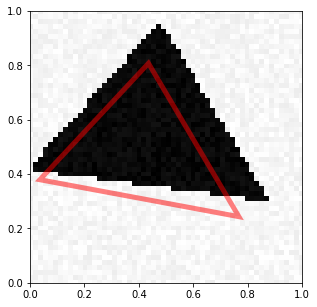

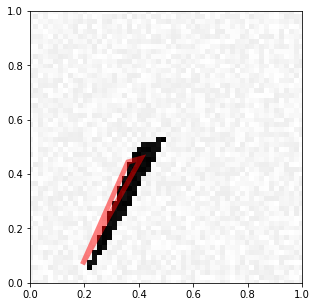

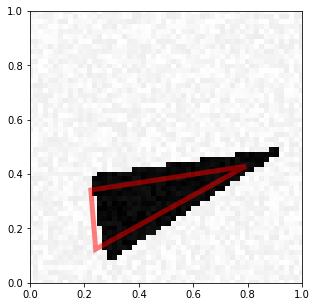

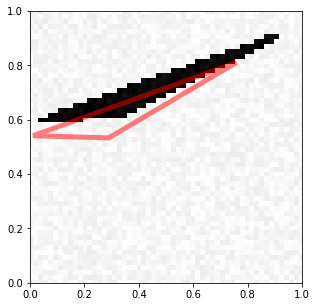

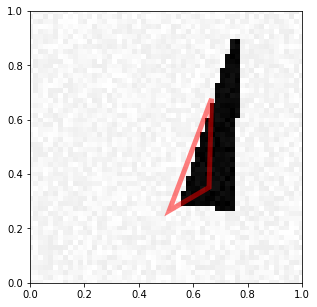

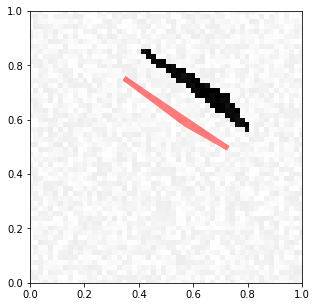

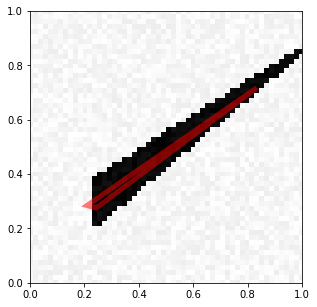

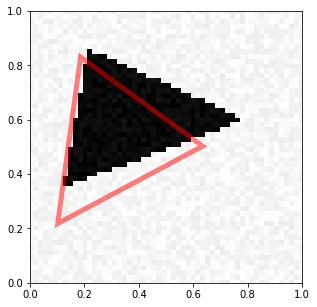

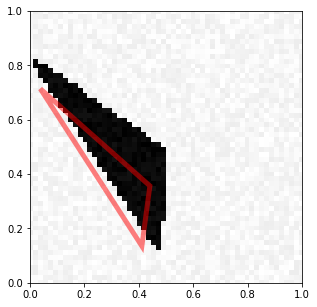

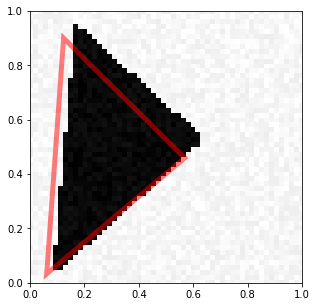

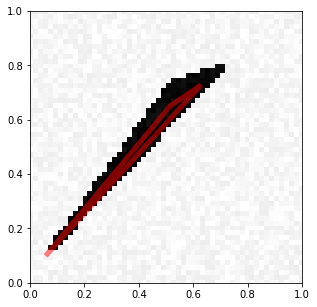

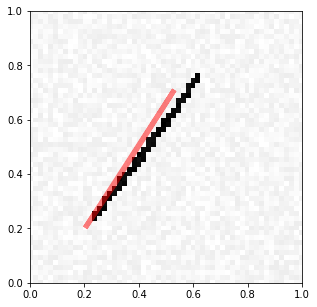

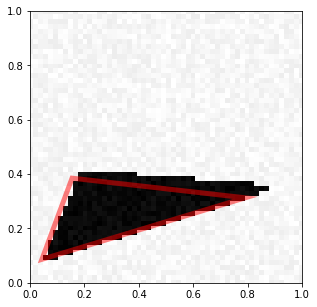

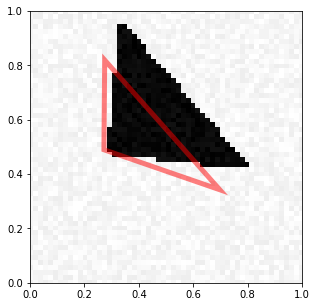

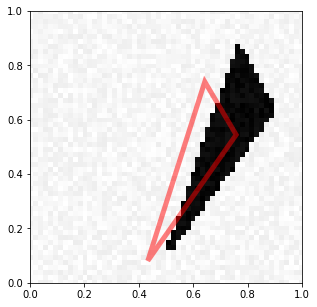

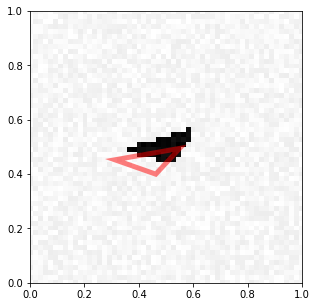

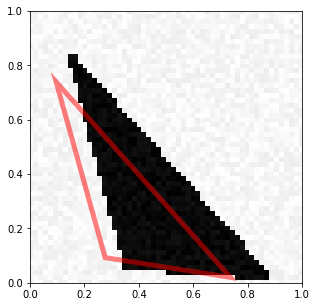

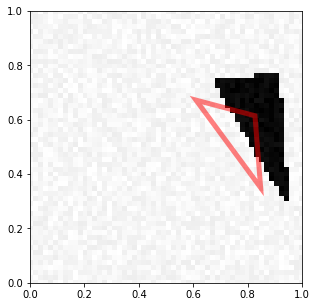

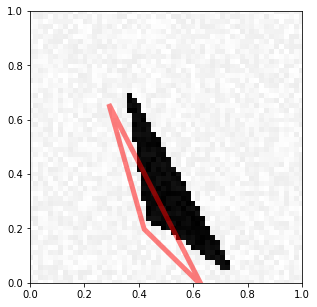

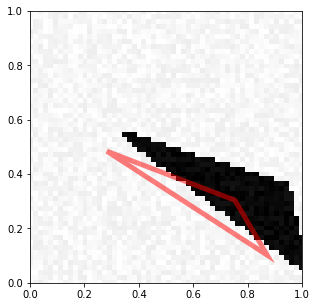

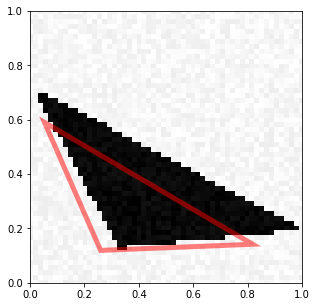

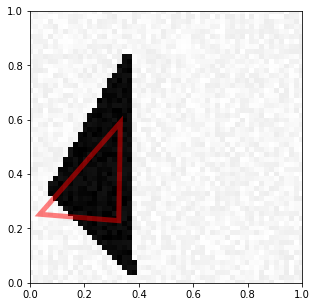

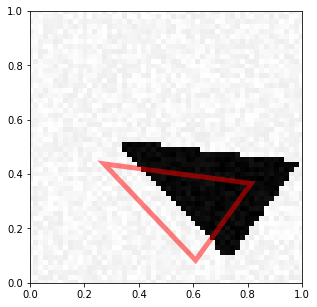

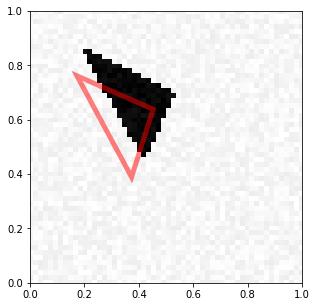

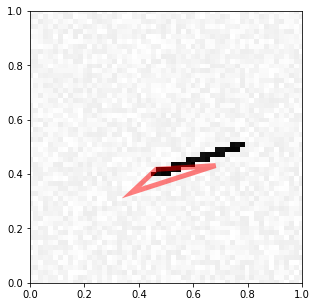

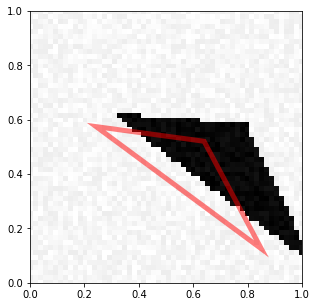

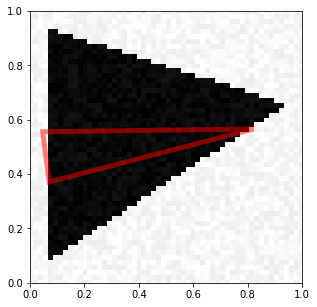

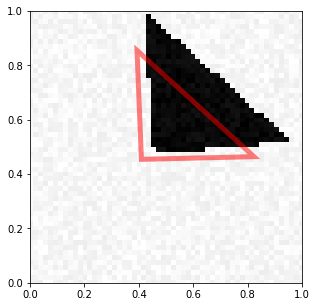

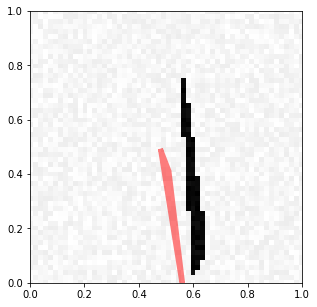

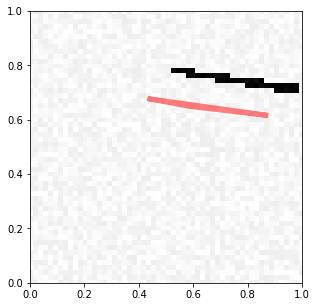

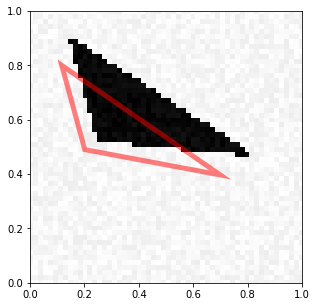

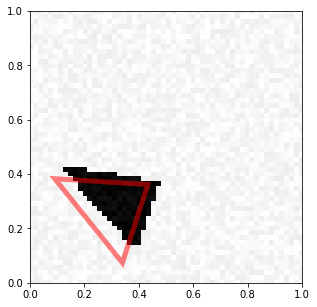

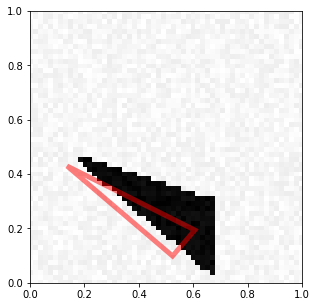

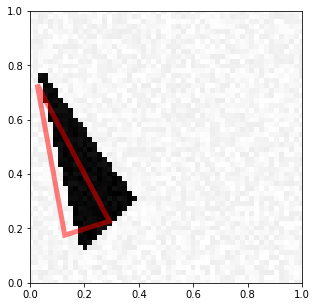

In [619]:
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
X_test = X_test.astype('float32')
for i in np.arange(200,300,2):
    visualize_prediction(X_test[i],Y_pred[i])

**Observation** 

To "normalize" Y datasets, I sorted vertices by increasing x coordinate, and in case of equality by y coordinate. I also tried to transform to polar coordinates and to sort by $\theta$ value. But this coding didn't work at all.

Here, I tried several networks, including a network similar to previous part, and a simple convolutional network with only one convolutional layer, one max pooling layer and 1 dense layer. But this simple network was not sufficient, even with a large number of epochs, which is considerably high (150 epochs).

So I considered several blocks of convolutional and max pooling layers, associated with mean squared error as loss function. I finally have 0.008 of MSE on test dataset. It seems to be a good result, but when I visualize predictions, I can see big errors on triangles, and especially on very flat triangles.
So maybe I should come back to simpler networks.

# 7 -  Image denoising

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise,imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    
    return generate_a_drawing(figsize, U, V, noise)


In [78]:
def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 50 == 0:
            print(i)
        category = np.random.randint(3)
        n = np.random.randint(low=1,high=noise+1)
        
        if category == 0:
            [X[i],Y[i]] = generate_a_rectangle(n, free_location)
        elif category == 1: 
            [X[i],Y[i]] = generate_a_disk(n, free_location)
        else:
            [X[i], Y[i]] = generate_a_triangle(n, free_location)
    Y = Y / 255
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]



def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, 20,True)
    return [X_test, Y_test]

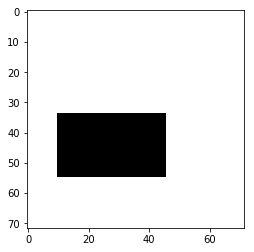

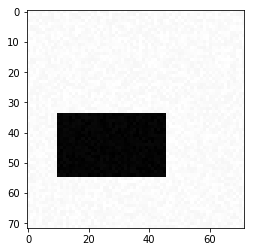

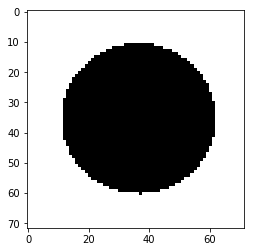

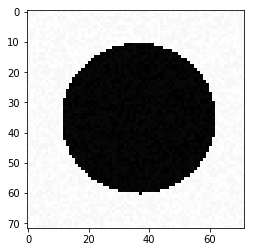

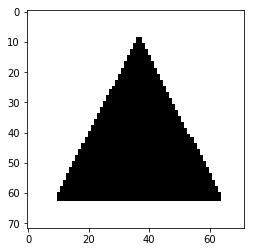

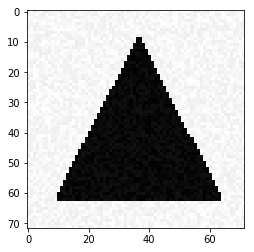

In [4]:

plt.figure()
im = generate_a_rectangle(10, True)
plt.imshow(im[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.figure()
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


plt.figure()
im = generate_a_disk(10)
plt.imshow(im[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.figure()
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


plt.figure()
im = generate_a_triangle(20, False)
plt.imshow(im[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.figure()
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


In [92]:
X_train,Y_train = generate_dataset_denoising(1500,20,True)
X_test,Y_test = generate_test_set_denoising()

Creating data:
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
Creating data:
0
50
100
150
200
250


In [93]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
X_train = X_train.astype('float32')

X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
X_test = X_test.astype('float32')

Y_train = Y_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
Y_train = Y_train.astype('float32')

Y_test = Y_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
Y_test = Y_test.astype('float32')

input_shape = (IMAGE_SIZE, IMAGE_SIZE,1)
print(input_shape)

(72, 72, 1)


In [94]:
model = Sequential()
model.add(Conv2D(64,kernel_size=(3,3),input_shape=input_shape,activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(2,2),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))

In [95]:
model.compile(loss='binary_crossentropy',
optimizer='adam',metrics=['accuracy'])

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 72, 72, 64)        640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 36, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 18, 18, 64)        16448     
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 36, 36, 64)        36928     
__________

In [97]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.001, patience=2)
callbacks=[early_stopping]
model.fit(X_train, Y_train, batch_size=32, epochs=10,verbose=1, validation_data=(X_test, Y_test),callbacks=callbacks)


Train on 1500 samples, validate on 300 samples
Epoch 1/10
1500/1500 [==============================] - 133s 89ms/step - loss: 0.1591 - acc: 0.9446 - val_loss: 0.0194 - val_acc: 0.9930
Epoch 2/10
1500/1500 [==============================] - 129s 86ms/step - loss: 0.0144 - acc: 0.9949 - val_loss: 0.0118 - val_acc: 0.9958
Epoch 3/10
1500/1500 [==============================] - 104s 69ms/step - loss: 0.0096 - acc: 0.9965 - val_loss: 0.0086 - val_acc: 0.9967
Epoch 4/10
1500/1500 [==============================] - 104s 69ms/step - loss: 0.0076 - acc: 0.9972 - val_loss: 0.0070 - val_acc: 0.9972
Epoch 5/10
1500/1500 [==============================] - 120s 80ms/step - loss: 0.0063 - acc: 0.9976 - val_loss: 0.0059 - val_acc: 0.9976
Epoch 6/10
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0050 - acc: 0.9981 - val_loss: 0.0052 - val_acc: 0.9980
Epoch 7/10
1500/1500 [==============================] - 125s 83ms/step - loss: 0.0044 - acc: 0.9983 - val_loss: 0.0038 - val_acc: 0

In [98]:
## Results with 64 neurones by Conv layer AND 1000 data in train
model.evaluate(X_test,Y_test)

300/300 [==============================] - 5s 17ms/step


[0.0024423144043733678, 0.99911072174708049]

In [99]:
pred = model.predict(X_test)

predicted


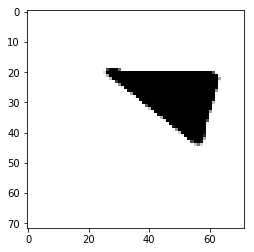

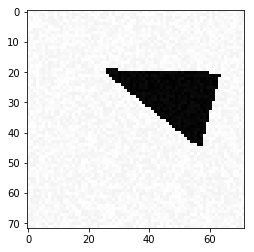

Cleaned image


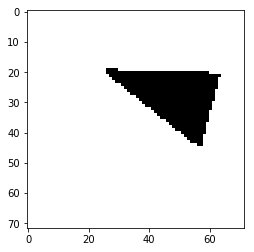

predicted


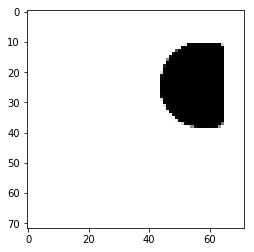

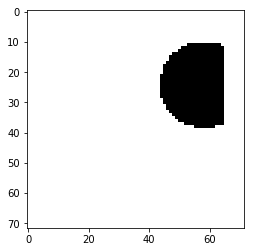

Cleaned image


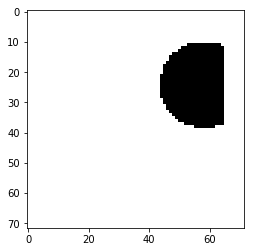

predicted


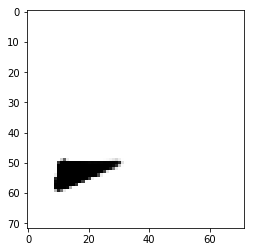

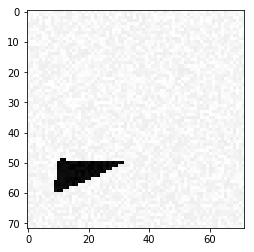

Cleaned image


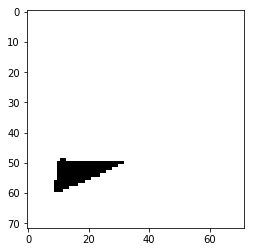

predicted


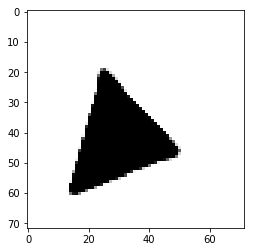

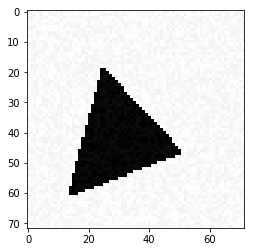

Cleaned image


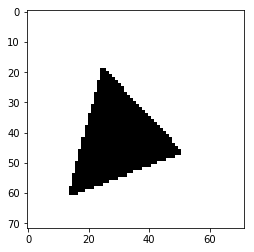

predicted


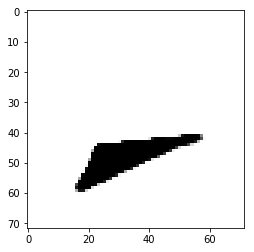

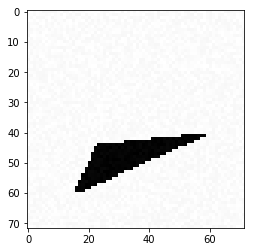

Cleaned image


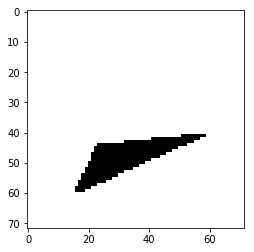

predicted


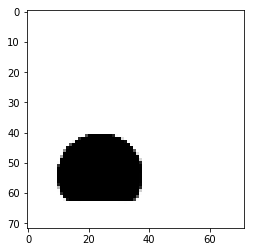

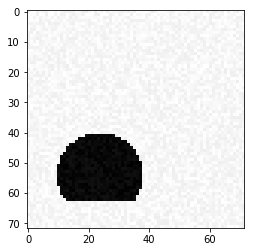

Cleaned image


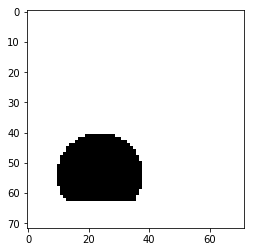

predicted


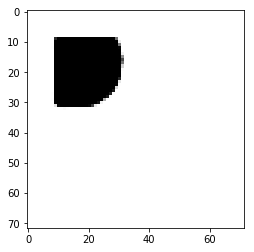

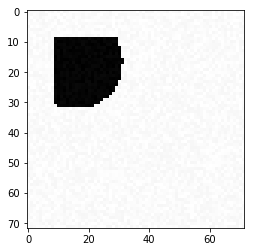

Cleaned image


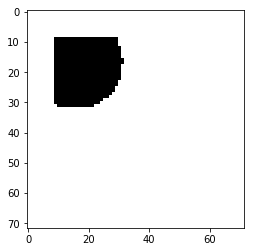

predicted


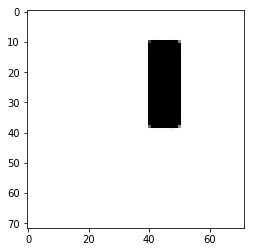

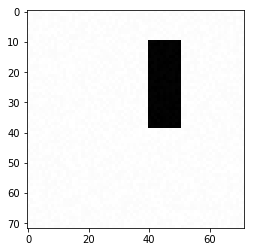

Cleaned image


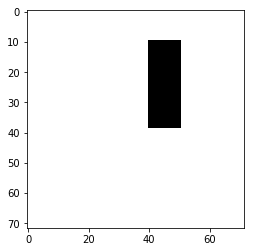

predicted


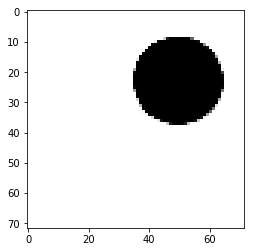

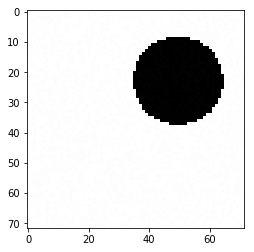

Cleaned image


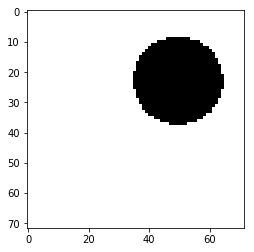

predicted


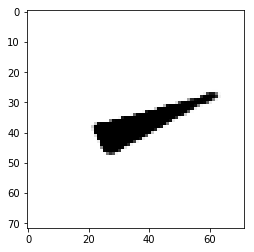

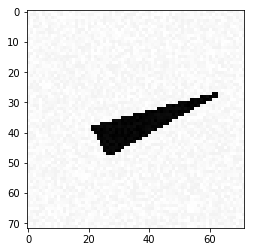

Cleaned image


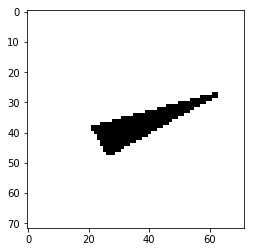

predicted


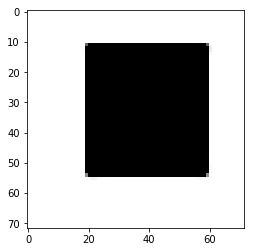

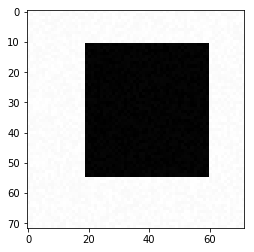

Cleaned image


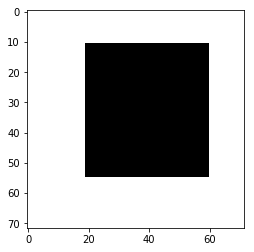

predicted


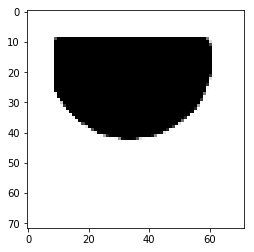

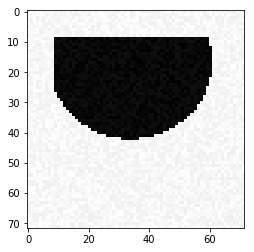

Cleaned image


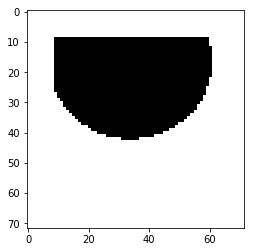

predicted


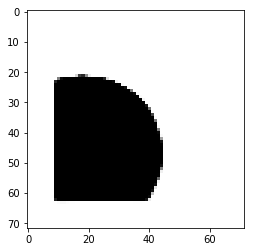

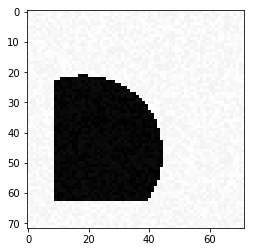

Cleaned image


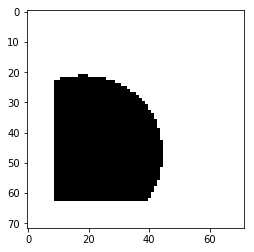

predicted


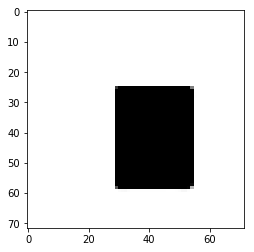

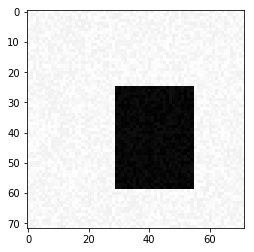

Cleaned image


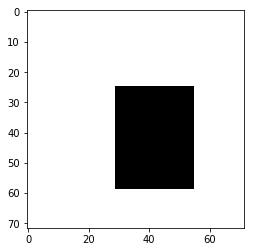

predicted


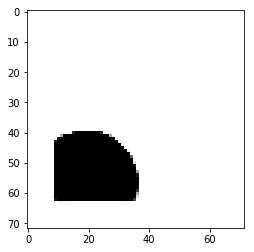

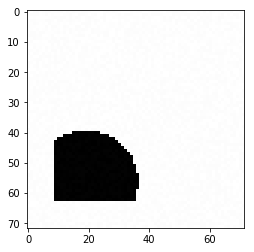

Cleaned image


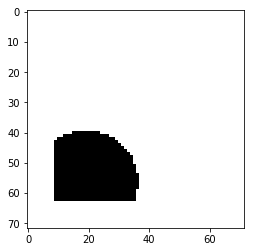

predicted


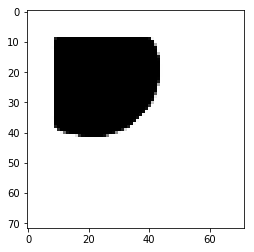

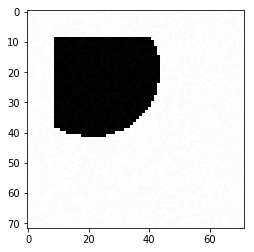

Cleaned image


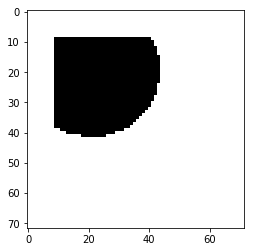

predicted


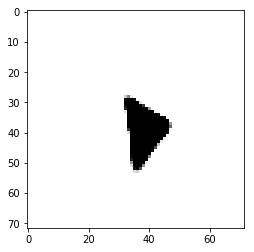

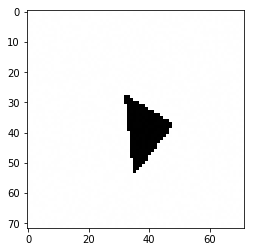

Cleaned image


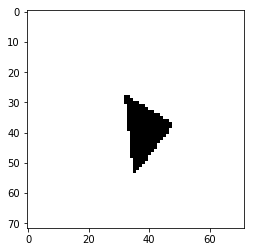

predicted


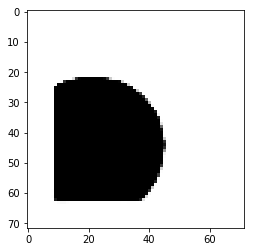

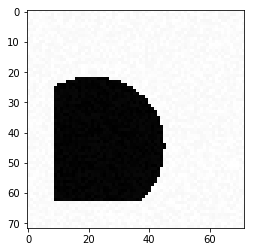

Cleaned image


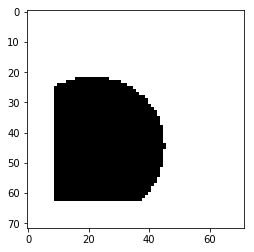

predicted


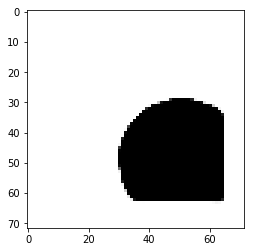

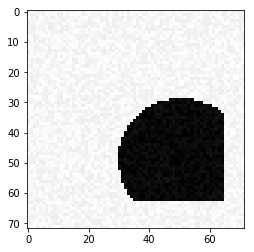

Cleaned image


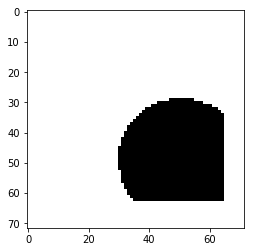

predicted


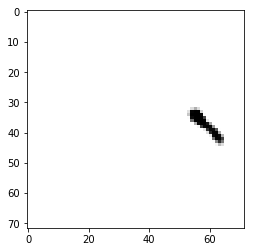

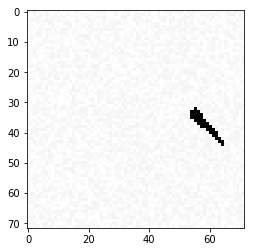

Cleaned image


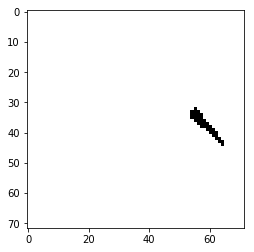

predicted


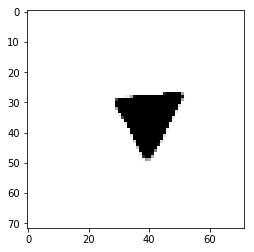

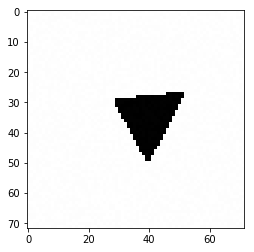

Cleaned image


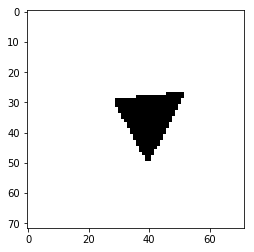

predicted


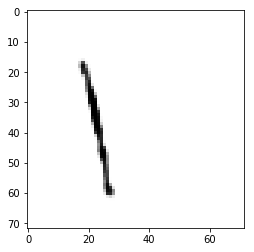

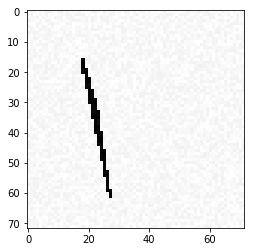

Cleaned image


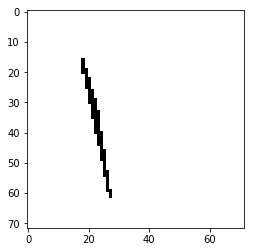

predicted


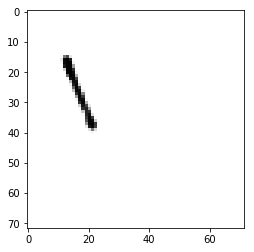

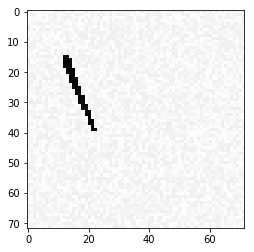

Cleaned image


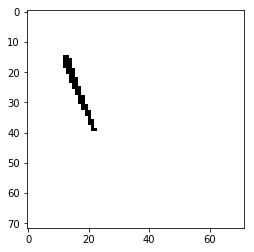

predicted


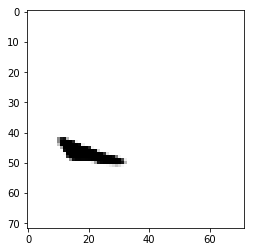

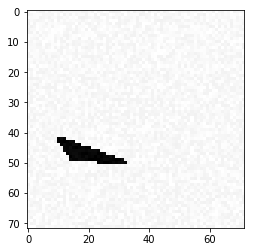

Cleaned image


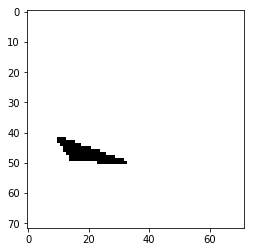

predicted


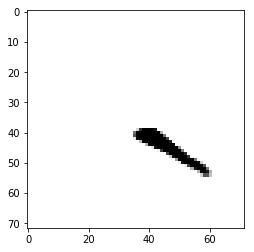

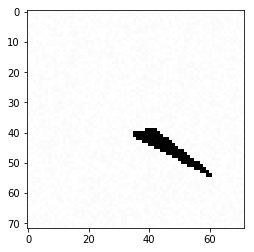

Cleaned image


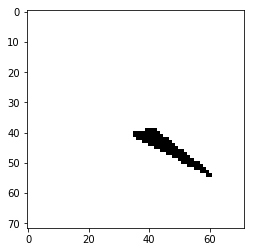

In [100]:
for i in np.arange(50,100,2):
    print('predicted')
    plt.imshow(pred[i].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
    plt.show()
    plt.imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
    plt.show()
    print('Cleaned image')
    plt.imshow(Y_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
    plt.show()

** Observation ** 

In order to build a denoising network, we have to consider here an autoencoder. 
In this  problem, convolution and maxpooling blocks are relevant and efficient. To recover cleaned image, Upsampling layer should also be consider, associated with convolution layers again, in order to capture valuable information, especially edges.

10 epochs are sufficient to reach more thant 99% accuracy, which is remarkable.

Here, two blocks to reduce dimensions, and two blocks to retrieve original dimensions are sufficient. I tried with one more block Convolution-MaxPooling and one Convolution-UpSampling, but it does not give better results, for an increasing time cost. Same thing for the number of filters in Convolution layers, it does not give better results.